In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA, FastICA
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
csv_path = '/content/drive/MyDrive/[04] College/[04] Year/SEM 2/CS4168/LAB 5/insurance.csv'
df = pd.read_csv(csv_path)
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


## EDA

In [4]:
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [5]:
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


From this, the categorical columns clearly are 'gender', 'smoker' and 'region'

In [6]:
df['gender'].value_counts()

,count
gender,
male,676
female,662


In [7]:
df['region'].value_counts()

,count
region,
southeast,364
southwest,325
northwest,325
northeast,324


In [8]:
df['smoker'].value_counts()

,count
smoker,
no,1064
yes,274


Checking for missing values and outliers, there is none

In [9]:
df.isna().sum()

,0
age,0
gender,0
bmi,0
children,0
smoker,0
region,0
insurance_cost,0


some basic stats on the numerical features of dataset

In [10]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Everything seems okay, some people have 0 kids or 5 kids which makes sense. The bmi min of 15 is low, but can exist and bmi of max 53 although very high can also exist

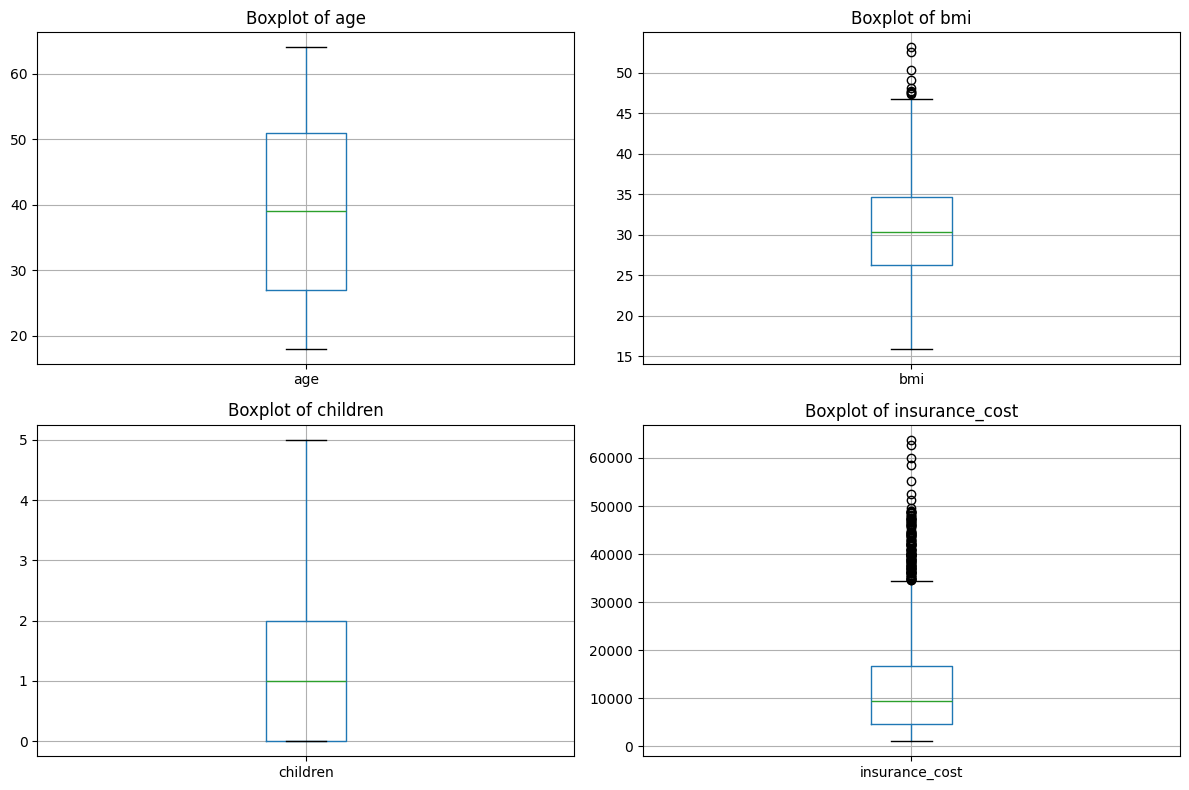

In [11]:
# numeric columns
columns = ['age', 'bmi', 'children', 'insurance_cost']

# 2x2 subplot makes it nicer
fig, axes = plt.subplots(2, 2, figsize=(12, 8))


axes = axes.flatten()

# Plot each column in its actual subplot
for i, col in enumerate(columns):
    df.boxplot(column=[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# Layout to make nicer
plt.tight_layout()
plt.show()

Okay so insurance and bmi seems to have lots of high outliers, but this could make sense as someone with high bmi may have high insurance costs (as they would be categorised more as a health risk)

In [12]:
df[df['bmi'] > 45]
df[df['insurance_cost'] > 30000]


,age,gender,bmi,children,smoker,region,insurance_cost
5,18,male,31.680,2,yes,southeast,34303.16720
9,18,female,36.850,0,yes,southeast,36149.48350
33,18,male,33.535,0,yes,northeast,34617.84065
38,18,male,38.170,0,yes,southeast,36307.79830
40,18,female,42.240,0,yes,southeast,38792.68560
...,...,...,...,...,...,...,...
1316,64,male,24.700,1,no,northwest,30166.61817
1317,64,female,31.300,2,yes,southwest,47291.05500
1319,64,female,33.800,1,yes,southwest,47928.03000
1325,64,male,33.880,0,yes,southeast,46889.26120


# Task 2

First creating a preprocessing pipeline to scale numerical features and one-hot encode categorical features, then split the data into training and testing sets so we can fairly evaluate our model’s performance.

In [35]:
preprocess_pipeline = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'children']),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['gender', 'region', 'smoker'])
    ],
    remainder='passthrough'
).set_output(transform="pandas")


y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)


In [56]:
X_transformed = preprocess_pipeline.fit_transform(X);

In [57]:
X_transformed.head()

,num__age,num__bmi,num__children,cat__gender_male,cat__region_northwest,cat__region_southeast,cat__region_southwest,cat__smoker_yes
0,-1.509965,0.509621,-0.078767,1.0,0.0,1.0,0.0,0.0
1,-1.509965,0.563756,-0.908614,1.0,0.0,1.0,0.0,0.0
2,-1.509965,-0.713331,-0.908614,0.0,0.0,0.0,0.0,0.0
3,-1.509965,1.312619,0.751079,0.0,0.0,0.0,0.0,0.0
4,-1.509965,0.813924,-0.908614,0.0,0.0,0.0,0.0,0.0


In [58]:
X_transformed.tail()

,num__age,num__bmi,num__children,cat__gender_male,cat__region_northwest,cat__region_southeast,cat__region_southwest,cat__smoker_yes
1333,1.765289,0.190555,0.751079,0.0,0.0,0.0,0.0,0.0
1334,1.765289,-0.619825,-0.908614,0.0,1.0,0.0,0.0,1.0
1335,1.765289,-0.697746,-0.908614,1.0,0.0,0.0,0.0,0.0
1336,1.765289,1.032923,0.751079,1.0,0.0,1.0,0.0,1.0
1337,1.765289,-1.132464,-0.908614,1.0,0.0,1.0,0.0,1.0


### Random Forest

Random forest pipeline using lab dimesionality redcuiton

In [41]:
pipe_rf = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('ttr', TransformedTargetRegressor(
        regressor=RandomForestRegressor(n_estimators=10),
        func=np.log, inverse_func=np.exp)
    )
])

N_FEATURES_OPTIONS = [2, 4, 6, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid_rf = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    }
]

search_rf = GridSearchCV(pipe_rf, param_grid_rf, n_jobs=-1, cv=5, refit=True)
search_rf.fit(X_train, y_train)

print("Best RF CV score = %0.3f:" % search_rf.best_score_)
print("Best RF parameters: ", search_rf.best_params_)

RF_best_model = search_rf.best_estimator_

Best RF CV score = 0.851:
Best RF parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 6, 'ttr__regressor__max_depth': 4}


### Linear regression

Linear regression pipeline using lab dimesionality redcuiton

In [42]:
pipe_lr = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('ttr', TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=np.log, inverse_func=np.exp)
    )
])

FIT_INTERCEPT_OPTIONS = [False, True]

param_grid_lr = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    },
    {
        'reduce_dim': [RFE(SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    }
]

search_lr = GridSearchCV(pipe_lr, param_grid_lr, n_jobs=-1, cv=5, refit=True)
search_lr.fit(X_train, y_train)

print("Best LR CV score = %0.3f:" % search_lr.best_score_)
print("Best LR parameters: ", search_lr.best_params_)

LR_best_model = search_lr.best_estimator_

Best LR CV score = 0.535:
Best LR parameters:  {'reduce_dim': RFE(estimator=LinearRegression()), 'reduce_dim__n_features_to_select': 6, 'ttr__regressor__fit_intercept': True}


### Gradient boosting

New Gradient boosting as model 3 using lab dimesionality redcuiton

In [43]:
pipe_gb = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('ttr', TransformedTargetRegressor(
        regressor=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
        func=np.log, inverse_func=np.exp)
    )
])

param_grid_gb = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    },
    {
        'reduce_dim': [RFE(SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
    }
]

search_gb = GridSearchCV(pipe_gb, param_grid_gb, n_jobs=-1, cv=5, refit=True)
search_gb.fit(X_train, y_train)

print("Best GB CV score = %0.3f:" % search_gb.best_score_)
print("Best GB parameters: ", search_gb.best_params_)

GB_best_model = search_gb.best_estimator_

Best GB CV score = 0.843:
Best GB parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 8}


In [47]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):

    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)

    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)

    return _mse, _mae, _r2

In [48]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
GB_mse, GB_mae, GB_r2 = evaluate_model(X_test, y_test, GB_best_model)

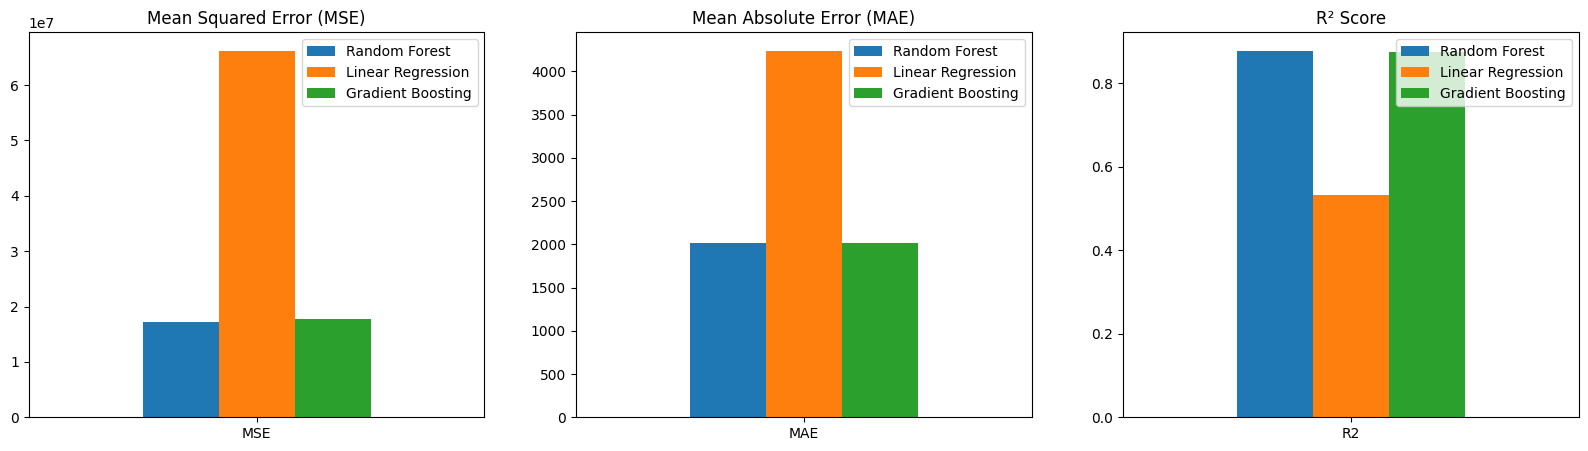

In [50]:
df_mse = pd.DataFrame({
    'Random Forest': RF_mse,
    'Linear Regression': LR_mse,
    'Gradient Boosting': GB_mse
}, index=['MSE'])

df_mae = pd.DataFrame({
    'Random Forest': RF_mae,
    'Linear Regression': LR_mae,
    'Gradient Boosting': GB_mae
}, index=['MAE'])

df_r2 = pd.DataFrame({
    'Random Forest': RF_r2,
    'Linear Regression': LR_r2,
    'Gradient Boosting': GB_r2
}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
df_mse.plot.bar(rot=0, ax=axes[0], title="Mean Squared Error (MSE)")
df_mae.plot.bar(rot=0, ax=axes[1], title="Mean Absolute Error (MAE)")
df_r2.plot.bar(rot=0, ax=axes[2], title="R² Score")
plt.show()

### Task 2 writeup

The extra model I did was a gradient boosting model applying PCA/RFE for dimensionality reduction like the lab. My best cross-validation scores were 0.851 for Random Forest (RF), 0.535 for Linear Regression (LR), and 0.843 for Gradient Boosting(GB). The test-set results show that RF and GB outperform LR in terms of both predictive accuracy (MSE and MAE) and R^².

RF achieved the highest cross-validation score (0.851) and demonstrated strong performance on the test set. It benefited from an optimal max_depth of 4, suggesting that controlling tree depth helped generalise better.

LR showed the lowest performance, with a cross-validation score of 0.535. Although it’s easy to interpret and fast to train, it struggled with the non-linear relationships in insurance costs.

Gradient Boosting closely rivalled Random Forest, reaching a cross-validation score of 0.843. It combines sequentially trained weak learners (decision trees) to reduce bias and variance. While slightly behind RF in cross-validation, its performance on the test set remains competitive.

In summary, RF and GB performed significantly better than LR, likely due to their ability to capture complex relationships in the data. Among the two ensembles, RF slightly outperformed GB in cross-validation, although the difference was small.








# Task 3

 I replaced PCA and RFE used from lab with FastICA and TruncatedSVD which are different dimensionality reduction techniques. I apllied them two RF and GB and then evalute

In [52]:
pipe_rf_task3 = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('ttr', TransformedTargetRegressor(
        regressor=RandomForestRegressor(n_estimators=10),
        func=np.log, inverse_func=np.exp)
    )
])

param_grid_rf_task3 = [
    {
        'reduce_dim': [FastICA(), TruncatedSVD()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    }
]

search_rf_task3 = GridSearchCV(pipe_rf_task3, param_grid_rf_task3, n_jobs=-1, cv=5, refit=True)
search_rf_task3.fit(X_train, y_train)

print("Best RF (Task 3) CV score = %0.3f:" % search_rf_task3.best_score_)
print("Best RF (Task 3) parameters: ", search_rf_task3.best_params_)

pipe_gb_task3 = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('ttr', TransformedTargetRegressor(
        regressor=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
        func=np.log, inverse_func=np.exp)
    )
])

param_grid_gb_task3 = [
    {
        'reduce_dim': [FastICA(), TruncatedSVD()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    }
]

search_gb_task3 = GridSearchCV(pipe_gb_task3, param_grid_gb_task3, n_jobs=-1, cv=5, refit=True)
search_gb_task3.fit(X_train, y_train)

print("Best GB (Task 3) CV score = %0.3f:" % search_gb_task3.best_score_)
print("Best GB (Task 3) parameters: ", search_gb_task3.best_params_)

RF_best_model_task3 = search_rf_task3.best_estimator_
GB_best_model_task3 = search_gb_task3.best_estimator_

Best RF (Task 3) CV score = 0.816:
Best RF (Task 3) parameters:  {'reduce_dim': TruncatedSVD(), 'reduce_dim__n_components': 8, 'ttr__regressor__max_depth': 8}
Best GB (Task 3) CV score = 0.824:
Best GB (Task 3) parameters:  {'reduce_dim': FastICA(), 'reduce_dim__n_components': 8}


In [53]:
RF_mse_task3, RF_mae_task3, RF_r2_task3 = evaluate_model(X_test, y_test, RF_best_model_task3)
GB_mse_task3, GB_mae_task3, GB_r2_task3 = evaluate_model(X_test, y_test, GB_best_model_task3)

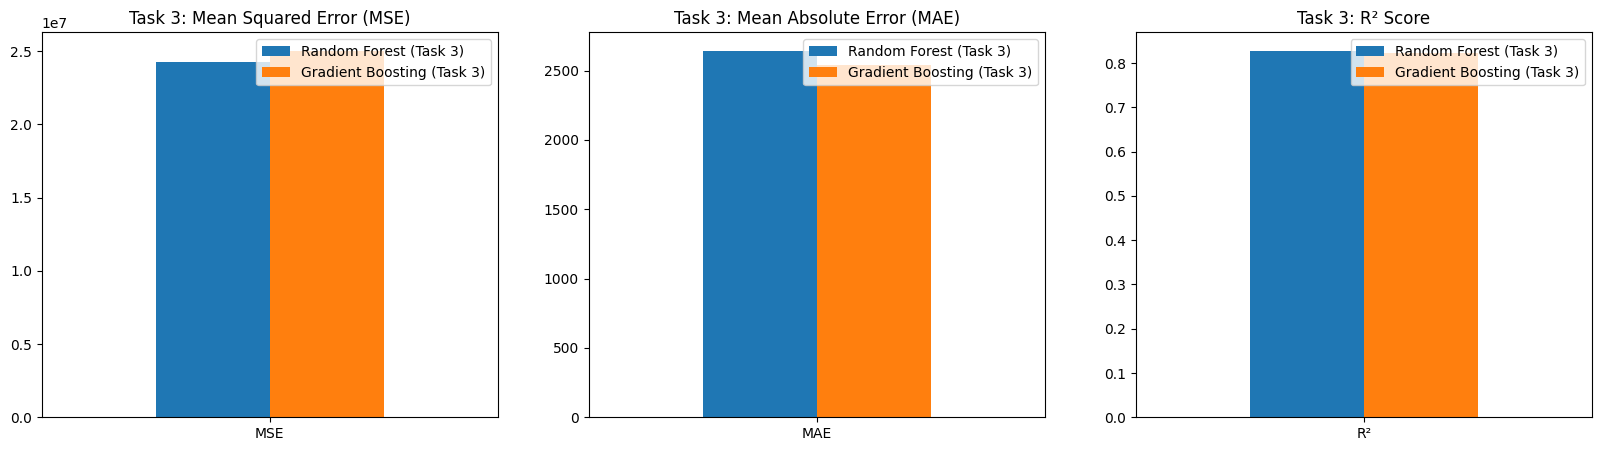

In [54]:
df_mse_task3 = pd.DataFrame({
    'Random Forest (Task 3)': RF_mse_task3,
    'Gradient Boosting (Task 3)': GB_mse_task3
}, index=['MSE'])
df_mae_task3 = pd.DataFrame({
    'Random Forest (Task 3)': RF_mae_task3,
    'Gradient Boosting (Task 3)': GB_mae_task3
}, index=['MAE'])
df_r2_task3 = pd.DataFrame({
    'Random Forest (Task 3)': RF_r2_task3,
    'Gradient Boosting (Task 3)': GB_r2_task3
}, index=['R²'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
df_mse_task3.plot.bar(rot=0, ax=axes[0], title="Task 3: Mean Squared Error (MSE)")
df_mae_task3.plot.bar(rot=0, ax=axes[1], title="Task 3: Mean Absolute Error (MAE)")
df_r2_task3.plot.bar(rot=0, ax=axes[2], title="Task 3: R² Score")
plt.show()

So for taks 3, I incorporated two new dimensionality reduction methods, FastICA and TruncatedSVD to Random Forest (RF) and Gradient Boosting (GB). Both models identified FastICA with 8 components as the best choice, wiht random forest resulting in rougly 2.4e^7 for MSE and rougly 2,500 for MAE in the test set, alongside R² scores rougly around 0.85. These outcomes indicate that FastICA captures core features in the insurance dataset without losing critical predictive signals. By focusing on eight independent components, the models effectively minimise noise and maintain strong predictive power.

Comparing Random Forest and Gradient Boosting, both exhibit very similar performance when combined with FastICA. This suggests that extracting underlying independent sources works well for ensemble methods, likely due to the complex, non-linear nature of insurance data.

Overall, the use of FastICA shows promise in improving (or at least maintaining) predictive accuracy relative to the more conventional PCA and RFE methods from task 2. Reducing dimensionality helps each ensemble model focus on meaningful components, potentially reducing overfitting and computational costs. These results highlight that careful selection of dimensionality reduction can enhance performance in regression tasks involving complex, real-world data like insurance costs.